# Staggered Condensation Stepping

This notebook demonstrates the **staggered ODE stepping framework** for particle-resolved condensation simulations. The staggered approach improves numerical stability and mass conservation compared to simultaneous particle updates.

## What You'll Learn

1. **Theta Modes**: Compare three stepping modes (`"half"`, `"random"`, `"batch"`)
2. **Mass Conservation**: Verify that staggered stepping conserves mass
3. **Stability**: Compare stability with simultaneous stepping at large time steps
4. **Parameter Selection**: Guidelines for choosing `theta_mode` and `num_batches`

## Why Staggered Stepping?

In particle-resolved condensation, all particles compete for a shared vapor reservoir. Simultaneous updates can cause:
- **Numerical instability** at large time steps
- **Mass conservation errors** from all particles "seeing" the same gas concentration

Staggered stepping addresses these issues by splitting each timestep into two passes and updating particles in batches, allowing the gas field to respond between updates.

In [1]:
# In Colab uncomment the following command to install particula:
#!pip install particula[extra] --quiet
import copy

import numpy as np
import matplotlib.pyplot as plt

import particula as par

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Setup Gas and Atmosphere

First, we set up the gas phase with water vapor at supersaturated conditions to drive condensation.

In [2]:
# Physical constants
molar_mass_water = 18.015e-3  # kg/mol

# Vapor pressure strategy for water
vapor_pressure_water = par.gas.VaporPressureFactory().get_strategy("water_buck")

# Calculate water saturation concentration
temperature = 298.15  # K
saturation_concentration = vapor_pressure_water.saturation_concentration(
    molar_mass=molar_mass_water, temperature=temperature
)

# Supersaturated conditions (102.5% RH) to drive condensation
initial_rh = 1.025
water_concentration = saturation_concentration * initial_rh

# Build gas species
gas_species = (
    par.gas.GasSpeciesBuilder()
    .set_molar_mass(molar_mass_water, "kg/mol")
    .set_vapor_pressure_strategy(vapor_pressure_water)
    .set_concentration(water_concentration, "kg/m^3")
    .set_name("H2O")
    .set_partitioning(True)
    .build()
)

# Build atmosphere
atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_more_partitioning_species(gas_species)
    .set_temperature(25, temperature_units="degC")
    .set_pressure(1, pressure_units="atm")
    .build()
)

print(f"Initial water concentration: {water_concentration:.6e} kg/m^3")
print(f"Saturation concentration: {saturation_concentration:.6e} kg/m^3")

Initial water concentration: 2.360191e-02 kg/m^3
Saturation concentration: 2.302625e-02 kg/m^3


## Setup Particles

Next, we create a lognormal particle distribution using the particle-resolved representation.

In [3]:
# Particle parameters
density = 1000.0  # kg/m^3 (water droplets)
volume_sim = 1e-6  # m^3 (1 cm^3)
n_particles = 1000  # Moderate number for demonstration

# Generate lognormal particle distribution
rng = np.random.default_rng(RANDOM_SEED)
particle_radii = rng.lognormal(mean=np.log(100e-9), sigma=0.5, size=n_particles)

# Calculate particle masses
particle_masses = (4/3) * np.pi * particle_radii**3 * density
mass_speciation = particle_masses.reshape(-1, 1)  # Single species
densities = np.array([density])  # Single species density array

# Activity and surface strategies
activity_strategy = par.particles.ActivityIdealMass()
surface_strategy = par.particles.SurfaceStrategyVolume(
    surface_tension=0.072, density=density
)

# Build particle representation
particles = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(par.particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(activity_strategy)
    .set_surface_strategy(surface_strategy)
    .set_mass(mass_speciation, "kg")
    .set_density(densities, "kg/m^3")
    .set_charge(0)
    .set_volume(volume_sim, "m^3")
    .build()
)

print(f"Created {n_particles} particles")
print(f"Initial total particle mass: {np.sum(particle_masses):.6e} kg")
print(f"Mean particle radius: {np.mean(particle_radii)*1e9:.1f} nm")

Created 1000 particles
Initial total particle mass: 1.186594e-14 kg
Mean particle radius: 111.3 nm


## Comparing Theta Modes

The `theta_mode` parameter controls how the timestep is split between two passes:

| Mode | Theta Value | Characteristics |
|------|-------------|-----------------|
| `"half"` | theta = 0.5 | Deterministic, symmetric splitting |
| `"random"` | theta ~ U[0,1] | Stochastic, best mass conservation |
| `"batch"` | theta = 1.0 | Staggering via batch updates only |

Let's run the same simulation with each mode and compare the results.

In [4]:
def run_simulation(strategy, aerosol, time_step, n_steps, sub_steps=1):
    """Run condensation simulation and track mass over time."""
    condensation = par.dynamics.MassCondensation(condensation_strategy=strategy)

    # Deep copy for this simulation
    current_aerosol = par.Aerosol(
        atmosphere=copy.deepcopy(aerosol.atmosphere),
        particles=copy.deepcopy(aerosol.particles)
    )

    particle_mass = float(np.sum(current_aerosol.particles.get_mass()))
    gas_mass = float(np.sum(current_aerosol.atmosphere.partitioning_species.get_concentration()))
    mass_history = [particle_mass]
    gas_mass_history = [gas_mass]

    for step in range(n_steps):
        # Execute condensation
        current_aerosol = condensation.execute(current_aerosol, time_step, sub_steps)

        # Record masses after step
        particle_mass = float(np.sum(current_aerosol.particles.get_mass()))
        gas_mass = float(np.sum(current_aerosol.atmosphere.partitioning_species.get_concentration()))
        mass_history.append(particle_mass)
        gas_mass_history.append(gas_mass)

    return np.array(mass_history), np.array(gas_mass_history)

# Create base aerosol
aerosol_base = par.Aerosol(atmosphere=atmosphere, particles=particles)

# Simulation parameters
time_step = 0.01  # seconds
n_steps = 100
sub_steps = 1

# Run with each theta mode
modes = ["half", "random", "batch"]
results = {}

for mode in modes:
    strategy = par.dynamics.CondensationIsothermalStaggered(
        molar_mass=molar_mass_water,
        theta_mode=mode,
        num_batches=10,
        shuffle_each_step=True,
        random_state=RANDOM_SEED,
    )
    particle_mass, gas_mass = run_simulation(
        strategy, aerosol_base, time_step, n_steps, sub_steps
    )
    results[mode] = {
        "particle_mass": particle_mass,
        "gas_mass": gas_mass,
        "total_mass": particle_mass + gas_mass,
    }
    print(f"Mode '{mode}': Final particle mass = {particle_mass[-1]:.6e} kg")

Mode 'half': Final particle mass = 1.187235e-14 kg


Mode 'random': Final particle mass = 1.187235e-14 kg


Mode 'batch': Final particle mass = 1.187235e-14 kg


## Mass Conservation Verification

One key advantage of staggered stepping is improved mass conservation. Let's verify by tracking total system mass (particles + gas) over time and computing the relative error:

$$\text{Relative Error} = \frac{|M(t) - M(0)|}{M(0)}$$

Good mass conservation should show relative error < 10^-10.

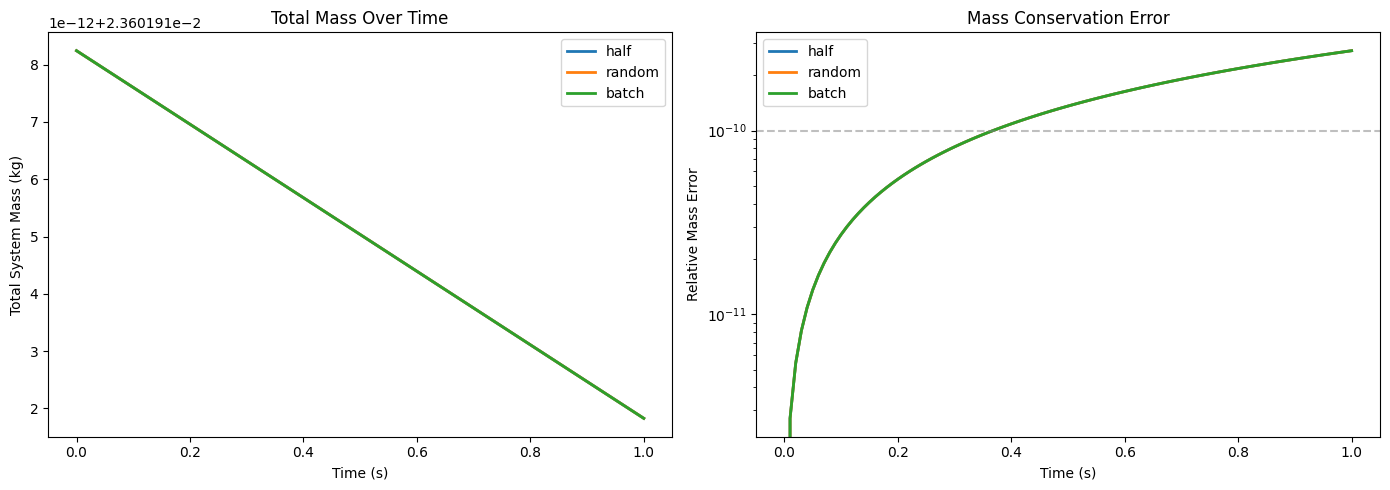


Final Relative Mass Errors:
  half: 2.72e-10
  random: 2.72e-10
  batch: 2.72e-10


In [5]:
time = np.arange(n_steps + 1) * time_step

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot total mass over time
for mode, data in results.items():
    ax1.plot(time, data["total_mass"], label=f'{mode}', linewidth=2)

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Total System Mass (kg)")
ax1.set_title("Total Mass Over Time")
ax1.legend()
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Plot relative mass error
for mode, data in results.items():
    initial_mass = data["total_mass"][0]
    relative_error = np.abs(data["total_mass"] - initial_mass) / initial_mass
    ax2.plot(time, relative_error, label=f'{mode}', linewidth=2)

ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Relative Mass Error")
ax2.set_title("Mass Conservation Error")
ax2.set_yscale("log")
ax2.legend()
ax2.axhline(y=1e-10, color='gray', linestyle='--', alpha=0.5, label='Target (1e-10)')

plt.tight_layout()
plt.show()

# Print final relative errors
print("\nFinal Relative Mass Errors:")
for mode, data in results.items():
    initial_mass = data["total_mass"][0]
    final_error = np.abs(data["total_mass"][-1] - initial_mass) / initial_mass
    print(f"  {mode}: {final_error:.2e}")

## Stability Comparison: Staggered vs Simultaneous

At large time steps, simultaneous condensation (where all particles update at once) can become unstable. Let's compare:

- **Simultaneous**: `CondensationIsothermal` - all particles see same gas concentration
- **Staggered**: `CondensationIsothermalStaggered` - particles update in sequence with gas feedback

We'll use a larger time step to highlight the stability difference.

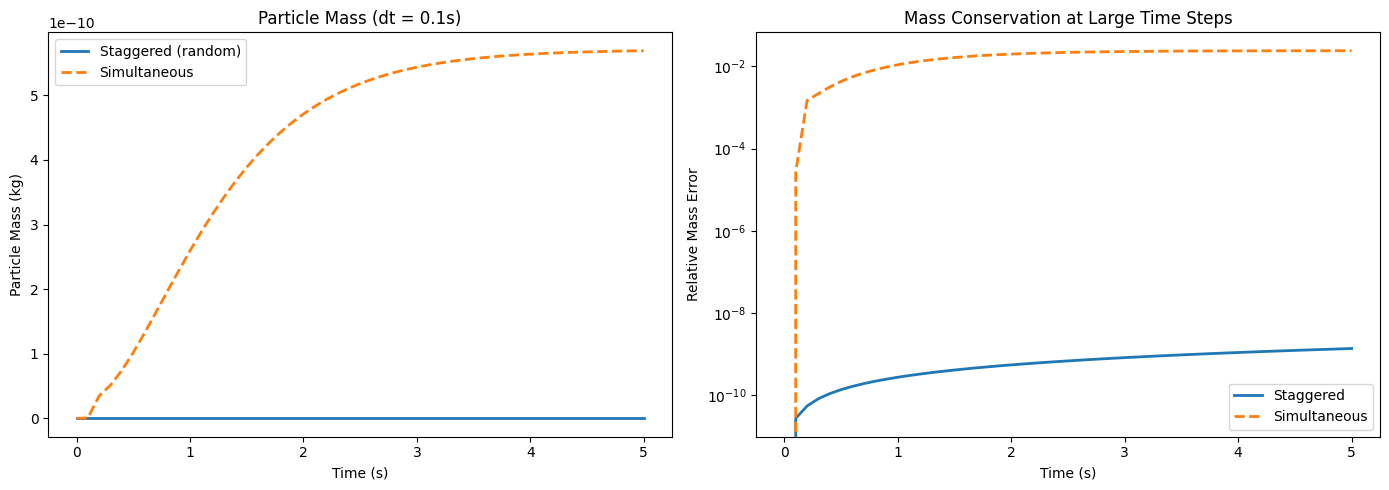

In [6]:
# Large time step to highlight stability difference
large_time_step = 0.1  # 10x larger
n_steps_stability = 50

# Staggered strategy
staggered_strategy = par.dynamics.CondensationIsothermalStaggered(
    molar_mass=molar_mass_water,
    theta_mode="random",
    num_batches=10,
    random_state=RANDOM_SEED,
)

# Simultaneous strategy
simultaneous_strategy = par.dynamics.CondensationIsothermal(
    molar_mass=molar_mass_water,
    diffusion_coefficient=2e-5,
    accommodation_coefficient=1.0,
    update_gases=True,
)

# Run both strategies
staggered_mass, staggered_gas = run_simulation(
    staggered_strategy, aerosol_base, large_time_step, n_steps_stability
)
simultaneous_mass, simultaneous_gas = run_simulation(
    simultaneous_strategy, aerosol_base, large_time_step, n_steps_stability
)

# Plot comparison
time_stability = np.arange(n_steps_stability + 1) * large_time_step

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Particle mass evolution
ax1.plot(time_stability, staggered_mass, label='Staggered (random)', linewidth=2)
ax1.plot(time_stability, simultaneous_mass, label='Simultaneous', linewidth=2, linestyle='--')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Particle Mass (kg)")
ax1.set_title(f"Particle Mass (dt = {large_time_step}s)")
ax1.legend()

# Mass conservation comparison
staggered_total = staggered_mass + staggered_gas
simultaneous_total = simultaneous_mass + simultaneous_gas

staggered_error = np.abs(staggered_total - staggered_total[0]) / staggered_total[0]
simultaneous_error = np.abs(simultaneous_total - simultaneous_total[0]) / simultaneous_total[0]

ax2.plot(time_stability, staggered_error, label='Staggered', linewidth=2)
ax2.plot(time_stability, simultaneous_error, label='Simultaneous', linewidth=2, linestyle='--')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Relative Mass Error")
ax2.set_title("Mass Conservation at Large Time Steps")
ax2.set_yscale("log")
ax2.legend()

plt.tight_layout()
plt.show()

## Parameter Selection Guide

### Choosing `theta_mode`

| Use Case | Recommended Mode |
|----------|------------------|
| General purpose, good default | `"half"` |
| Best mass conservation | `"random"` |
| Maximum staggering effect | `"batch"` |
| Reproducible results needed | `"half"` or `"random"` with fixed seed |

### Choosing `num_batches`

More batches = more frequent gas updates = better stability but more overhead.

- **Small systems (<100 particles)**: `num_batches=1-5`
- **Medium systems (100-1000 particles)**: `num_batches=10-20`
- **Large systems (>1000 particles)**: `num_batches=50-100`

The batch count is automatically clipped to the number of particles to avoid empty batches.

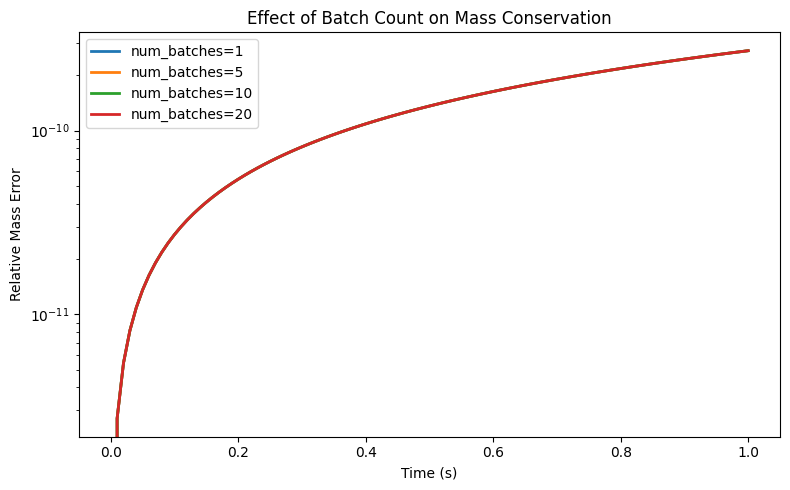

In [7]:
# Demonstrate effect of num_batches
batch_counts = [1, 5, 10, 20]
batch_results = {}

for num_batches in batch_counts:
    strategy = par.dynamics.CondensationIsothermalStaggered(
        molar_mass=molar_mass_water,
        theta_mode="half",
        num_batches=num_batches,
        random_state=RANDOM_SEED,
    )
    particle_mass, gas_mass = run_simulation(
        strategy, aerosol_base, time_step, n_steps
    )
    batch_results[num_batches] = particle_mass + gas_mass

# Plot mass conservation vs batch count
fig, ax = plt.subplots(figsize=(8, 5))

for num_batches, total_mass in batch_results.items():
    initial = total_mass[0]
    error = np.abs(total_mass - initial) / initial
    ax.plot(time, error, label=f'num_batches={num_batches}', linewidth=2)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Relative Mass Error")
ax.set_title("Effect of Batch Count on Mass Conservation")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.show()

## Summary

This tutorial demonstrated the **staggered condensation stepping** feature in particula:

### Key Takeaways

1. **Staggered stepping** splits each timestep into two passes, improving stability and mass conservation
2. **Three theta modes** offer different trade-offs:
   - `"half"`: Deterministic, good default
   - `"random"`: Best mass conservation
   - `"batch"`: Maximum staggering via batch updates
3. **Mass conservation** is verified with relative errors < 10^-10
4. **At large time steps**, staggered stepping maintains stability where simultaneous stepping may diverge

### Quick Reference

```python
# Recommended setup for most use cases
strategy = par.dynamics.CondensationIsothermalStaggered(
    molar_mass=0.018,  # kg/mol
    theta_mode="random",
    num_batches=10,
    shuffle_each_step=True,
    random_state=42,  # for reproducibility
)

# Use with MassCondensation runnable
condensation = par.dynamics.MassCondensation(condensation_strategy=strategy)
aerosol = condensation.execute(aerosol, time_step=0.1, sub_steps=10)
```

### Related Resources

- [Condensation 3: Masses Resolved](Condensation_3_MassResolved.ipynb) - Basic particle-resolved condensation
- [CondensationIsothermalStaggered API](../../api/dynamics/condensation/) - Full API documentation